Imports

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# review = pd.read_csv(r'C:/Users/abdul/Desktop/reviews_final.csv')

In [0]:
inspection = pd.read_csv(r"/content/drive/My Drive/DPA Project files/inspections_final.csv")

In [0]:
inspection.shape

(137846, 29)

### Subsetting inspections to routine inspections and recoding grades

In [0]:
inspection.head(1)

,serial_number,permit_number,facility_id_x,inspection_date,inspection_time,employee_id,inspection_demerits,inspection_grade,inspection_grade_new,inspection_result,violations,record_updated,inspection_type,business_id,name,address_x,city,latitude_x,longitude_x,stars,review_count,is_open,attributes,categories,zip_code,current_grade,current_demerits,previous_grade,date_previous
0,DA0001807,PR0000441,FA0002435,2007-12-05 00:00:00,2007-12-05 15:40:00,EE7000360,0.0,A,A,Compliant,-1,2013-02-21 22:26:12,Routine Inspection,CdxWhFBtjl0LBqlQEfxX8A,Pronto by Giada,3570 S Las Vegas Blvd,Las Vegas,36.116156,-115.175058,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00


In [0]:
inspection.inspection_type.unique()

array(['Routine Inspection', 'Re-inspection', 'Survey'], dtype=object)

In [0]:
inspection = inspection[inspection.inspection_type == 'Routine Inspection']

In [0]:
def recode_grade(x):
  if x.inspection_demerits <= 10:
    return 'P'
  else: return 'F'


In [0]:
inspection['clean_grade'] = inspection.apply(recode_grade, axis=1)

In [0]:
inspection.inspection_date = inspection.apply(lambda x: pd.to_datetime(x.inspection_date), axis=1)
inspection['year'] = pd.DatetimeIndex(inspection.inspection_date).year

In [0]:
inspection.year = inspection.year.astype(int)

In [0]:
inspection = inspection[inspection.year >= 2011]

In [0]:
inspection.to_csv(r"/content/drive/My Drive/DPA Project files/inspect_viz_data.csv")

Read inspection file here

In [0]:
inspection = pd.read_csv("/content/drive/My Drive/DPA Project files/inspect_viz_data.csv")

In [0]:
rev = review

In [0]:
#for viewing full information of cells
def display_dataframe_without_trim():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 100)

In [0]:
display_dataframe_without_trim()

### Cleaning and Tokenizing

In [0]:
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0,0,0,The food is always good and the prices are reasonable. Although it's not exactly a restaurant -...,2016-01-17 05:26:22
1,qm97yMwREr7BKkexlwLFbg,TTRVdTXKcq-xn6-1IWbwEw,Gyrez6K8f1AyR7dzW9fvAw,5.0,0,0,1,their pettuccine was fresh-made in the morning. it was very delicate and yummy! the owner and st...,2013-12-28 22:28:08
2,0AsmPiAQduxh5jE_si8cLA,C_hUvw2z0R-Rv0yZb6QCZA,dm6sO_Y8JdKTE1ZM955yug,5.0,0,0,0,ended up here because Raku was closed and it received great ratings on Yelp. I'm so glad I came...,2014-12-17 19:04:33
3,j3vP8537KHvoXNHQIr3haA,Z_HE_KKT7N-WddPTzUQC7A,jScBTQtdAt-8RshaiBEHgw,5.0,1,0,1,"Party of 3 ordered the fish tacos, pork belly banh mi, corn beef hash Benedict, and bam ham. Eve...",2018-05-28 20:56:05
4,f0B9-r14-bLudyu5S7aLhw,SvMGr_Oih7ivtzmnCL-Tmg,ujHiaprwCQ5ewziu0Vi9rw,1.0,1,0,0,We had dinner at the Bellagio Buffet last night. The service was OK. Our server was great but ki...,2013-12-07 00:14:06


In [0]:
# Map of all contractions
CONTRACTION_MAP = {
"ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
"could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
"doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
"haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he he will have",
"he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
"I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
"i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not",
"it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
"let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
"must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
"needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
"she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
"should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
"so's": "so as", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
"we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
"what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
"where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
"won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
"y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
"y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
"you'll've": "you will have", "you're": "you are", "you've": "you have"
}


In [0]:
# returns the input sentence with contractions expanded
def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



expand_contractions("Y'all can't expand contractions I'd think", CONTRACTION_MAP)

'You all cannot expand contractions I would think'

In [0]:
# Expanding contractions
rev['text_clean'] = rev.apply(lambda x: expand_contractions(str(x.text).lower(), CONTRACTION_MAP), axis=1)

In [0]:
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_clean
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0,0,0,The food is always good and the prices are reasonable. Although it's not exactly a restaurant -...,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...
1,qm97yMwREr7BKkexlwLFbg,TTRVdTXKcq-xn6-1IWbwEw,Gyrez6K8f1AyR7dzW9fvAw,5.0,0,0,1,their pettuccine was fresh-made in the morning. it was very delicate and yummy! the owner and st...,2013-12-28 22:28:08,their pettuccine was fresh-made in the morning. it was very delicate and yummy! the owner and st...
2,0AsmPiAQduxh5jE_si8cLA,C_hUvw2z0R-Rv0yZb6QCZA,dm6sO_Y8JdKTE1ZM955yug,5.0,0,0,0,ended up here because Raku was closed and it received great ratings on Yelp. I'm so glad I came...,2014-12-17 19:04:33,ended up here because raku was closed and it received great ratings on yelp. i am so glad i cam...
3,j3vP8537KHvoXNHQIr3haA,Z_HE_KKT7N-WddPTzUQC7A,jScBTQtdAt-8RshaiBEHgw,5.0,1,0,1,"Party of 3 ordered the fish tacos, pork belly banh mi, corn beef hash Benedict, and bam ham. Eve...",2018-05-28 20:56:05,"party of 3 ordered the fish tacos, pork belly banh mi, corn beef hash benedict, and bam ham. eve..."
4,f0B9-r14-bLudyu5S7aLhw,SvMGr_Oih7ivtzmnCL-Tmg,ujHiaprwCQ5ewziu0Vi9rw,1.0,1,0,0,We had dinner at the Bellagio Buffet last night. The service was OK. Our server was great but ki...,2013-12-07 00:14:06,we had dinner at the bellagio buffet last night. the service was ok. our server was great but ki...


In [0]:
# tokenize
rev['tokens'] = rev.apply(lambda x: nltk.word_tokenize(str(x.text_clean)), axis=1)

In [0]:
rev.tokens.head()

0    [the, food, is, always, good, and, the, prices, are, reasonable, ., although, it, is, not, exact...
1    [their, pettuccine, was, fresh-made, in, the, morning, ., it, was, very, delicate, and, yummy, !...
2    [ended, up, here, because, raku, was, closed, and, it, received, great, ratings, on, yelp, ., i,...
3    [party, of, 3, ordered, the, fish, tacos, ,, pork, belly, banh, mi, ,, corn, beef, hash, benedic...
4    [we, had, dinner, at, the, bellagio, buffet, last, night, ., the, service, was, ok., our, server...
Name: tokens, dtype: object

In [0]:
from nltk.corpus import stopwords

In [0]:
import string

In [0]:
stop_words = stopwords.words('english')
puncs = list(string.punctuation)
remove = stop_words + puncs
words = nltk.corpus.words.words()

In [0]:
remove

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [0]:
# returns a the input sentence with stop words, non-words, and punctuations removed
def clean_sent(sent_list):
    sent_list = [word for word in sent_list if word not in remove]
    sent_list = [word for word in sent_list if word.isalpha()]
    return sent_list

In [0]:
rev['tokens_clean'] = rev.apply(lambda x: clean_sent(x.tokens), axis=1 )

In [0]:
rev.tokens_clean.head()

0    [food, always, good, prices, reasonable, although, exactly, restaurant, like, snack, bar, limite...
1    [pettuccine, morning, delicate, yummy, owner, staffs, super, kind, delightful, also, veal, picca...
2    [ended, raku, closed, received, great, ratings, yelp, glad, came, one, better, meals, started, m...
3    [party, ordered, fish, tacos, pork, belly, banh, mi, corn, beef, hash, benedict, bam, ham, every...
4    [dinner, bellagio, buffet, last, night, service, server, great, kind, forgot, us, towards, end, ...
Name: tokens_clean, dtype: object

In [0]:
# pip install wordcloud

In [0]:
rev.shape

(896214, 12)

In [0]:
# drop redundant columns
rev.drop(columns=['text', 'tokens'], inplace=True)

In [0]:
# save files
rev.to_csv(r"C:/users/abdul/Desktop/review_tokenized.csv", encoding='utf-8', index=False)

### Corpus

In [0]:
rev = pd.read_csv(r"C:/users/abdul/Desktop/review_tokenized.csv")

In [0]:
sample = rev.sample(n=rev.shape[0], random_state=42)

In [0]:
sample.reset_index(drop=True, inplace=True)

### Word cloud

In [0]:
from wordcloud import WordCloud

In [0]:
def build_word_cloud(df, max_words=100, plt_width=20, plt_height=10):
    all_words = []
    # generating the corpus with repititions allowed
    for i in df.tokens_clean:
        try:
          a = i.split(',')
        except:
          continue
        for j in a:
            try:
                j = re.findall('[a-z]', j)
                word = ''.join(j)
                all_words.append(word)
            except:
                continue
    all_words = list(filter(lambda a: a not in ['las', 'vegas', 'food', 'place','restaurant'],
                             all_words))
    all_words_ = ' '.join(all_words)
    cloud = WordCloud(background_color="white", width=1600, height=800, 
                      max_words=max_words, random_state=42).generate(all_words_)
    plt.figure(figsize=(plt_width,plt_height))
    plt.imshow(cloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis('off')

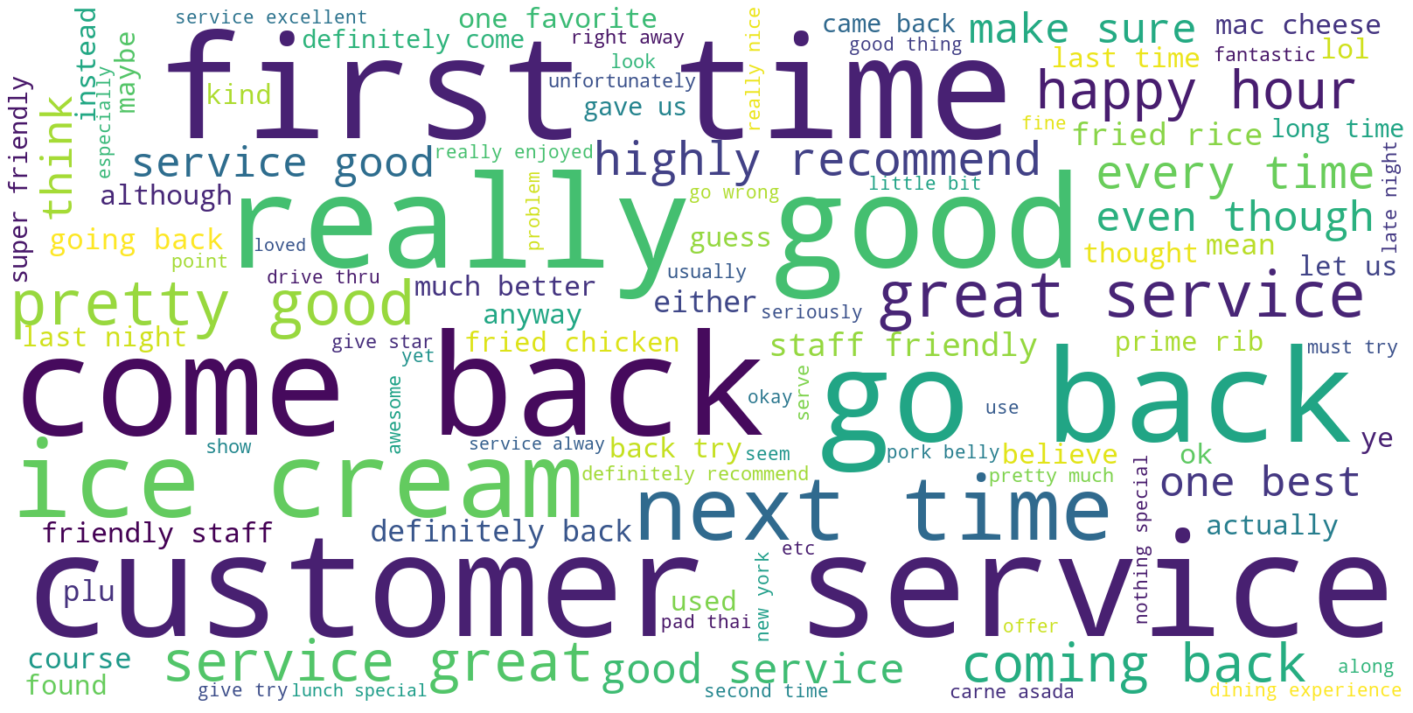

In [0]:
build_word_cloud(df=sample)

### Word cloud with Verbs removed

In [0]:
all_words = []
# generating the corpus with repititions allowed
for i in rev.tokens_clean.sample(100000):
    try:
      a = i.split(',')
    except: continue
    for j in a:
        try:
            j = re.findall('[a-z]', j)
            word = ''.join(j)
            all_words.append(word)
        except:
            continue
all_words = list(filter(lambda a: a not in ['las', 'vegas', 'food','drink', 'place','restaurant'],
                          all_words))

In [0]:
nltk.download('averaged_perceptron_tagger')

In [0]:
all_words = [i for i in all_words if i.isalpha()]
tagged = nltk.pos_tag(all_words)

tagged_ = [i[0] for i in tagged if not i[1].startswith('V')]
len(tagged), len(tagged_)

In [0]:
all_words_ = ' '.join(tagged_)
cloud = WordCloud(background_color="white", width=1600, height=800, normalize_plurals=False,
                  max_words=100, random_state=42).generate(all_words_)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')

NameError: ignored

In [0]:
rev.head()

### Word cloud for Pass and Fail

In [0]:
# Generate a sample of data containing past reviews for 1000 restaurants
# pass
s = inspection[inspection.clean_grade=='P'].sample(1000)
rev_sample = pd.DataFrame(columns=rev.columns)
for serial in s.serial_number:
  rev_sample = pd.concat([rev_sample, get_past_reviews(serial_number=serial, window=365)])

In [0]:
all_words = []
# generating the corpus with repititions allowed
for i in rev_sample.tokens_clean:
    try:
      a = i.split(',')
    except: continue
    for j in a:
        try:
            j = re.findall('[a-z]', j)
            word = ''.join(j)
            all_words.append(word)
        except:
            continue
all_words = list(filter(lambda a: a not in ['las', 'vegas', 'food','drink', 'place','restaurant'],
                          all_words))

In [0]:
all_words = [i for i in all_words if i.isalpha()]

In [0]:
tagged = nltk.pos_tag(all_words)
tagged_ = [i[0] for i in tagged if not i[1].startswith('V')]
len(tagged), len(tagged_)

(2314816, 1828178)

(-0.5, 1599.5, 799.5, -0.5)

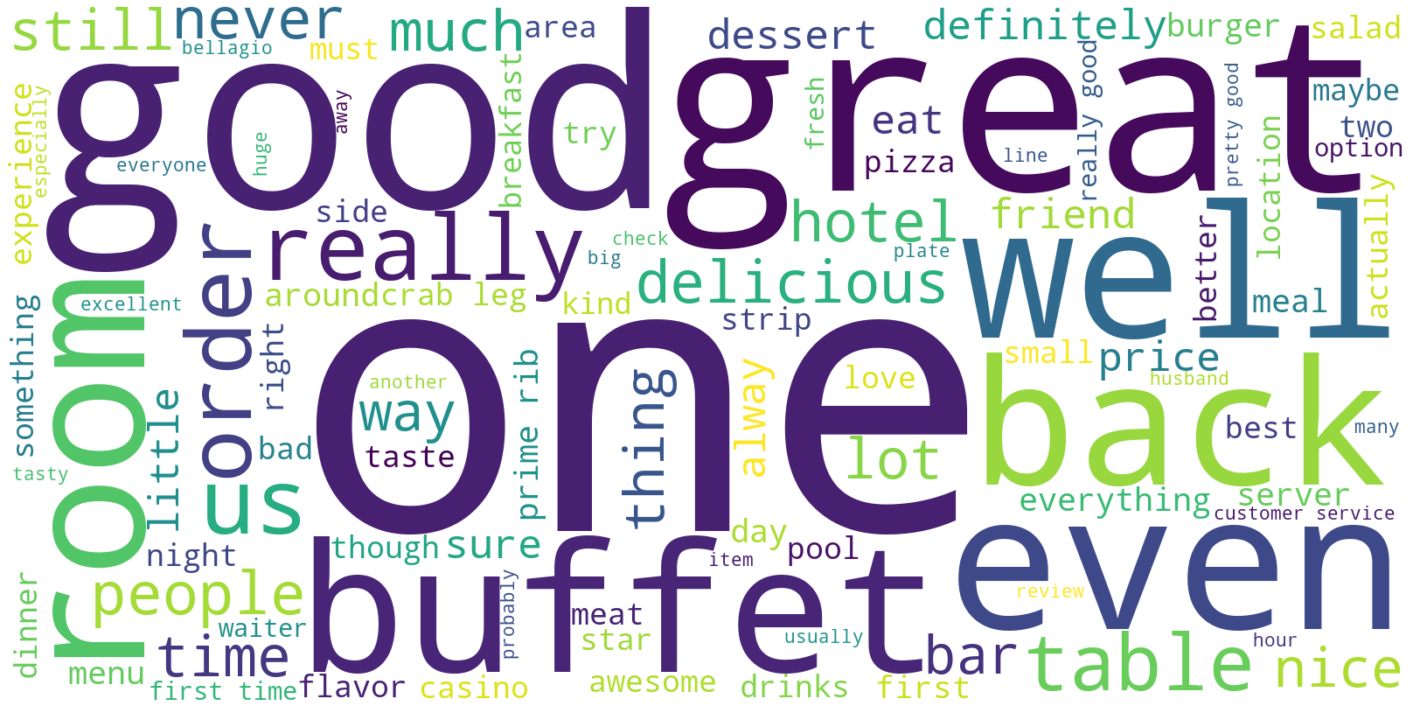

In [0]:
all_words_ = ' '.join(tagged_)
cloud = WordCloud(background_color="white", width=1600, height=800, 
                  max_words=100, random_state=42).generate(all_words_)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')

In [0]:
# Generate a sample of data containing past reviews for 1000 restaurants
# fail
s = inspection[(inspection.inspection_grade=='F') | (inspection.inspection_grade=='C')].sample(1000)
rev_sample = pd.DataFrame(columns=rev.columns)
for serial in s.serial_number:
  rev_sample = pd.concat([rev_sample, get_past_reviews(serial_number=serial, window=180)])

In [0]:
all_words = []
# generating the corpus with repititions allowed
for i in rev_sample.tokens_clean:
    try:
      a = i.split(',')
    except: continue
    for j in a:
        try:
            j = re.findall('[a-z]', j)
            word = ''.join(j)
            all_words.append(word)
        except:
            continue
all_words = list(filter(lambda a: a not in ['las', 'vegas', 'food','drink', 'place','restaurant','good','service','great'],
                          all_words))

In [0]:
all_words = [i for i in all_words if i.isalpha()]

In [0]:
tagged = nltk.pos_tag(all_words)
tagged_ = [i[0] for i in tagged if not i[1].startswith('V')]
len(tagged), len(tagged_)

(937411, 733362)

(-0.5, 1599.5, 799.5, -0.5)

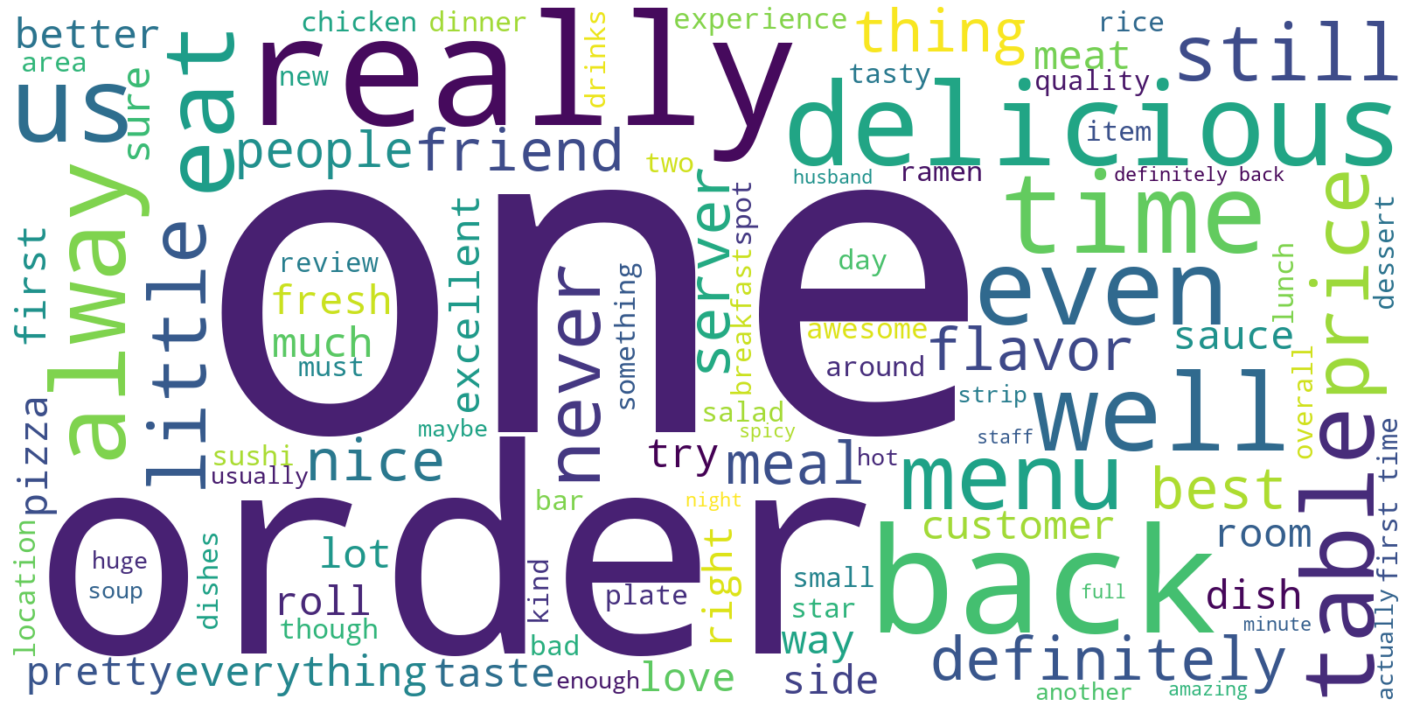

In [0]:
all_words_ = ' '.join(tagged_)
cloud = WordCloud(background_color="white", width=1600, height=800, 
                  max_words=100, random_state=42).generate(all_words_)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')

### Top 30 restaurants by ratings (with sufficient review count)

In [0]:
# What are the top restaurants in terms of stars
top = rev.groupby('business_id').agg({'business_id':['count'], 
                            'stars':['mean']}).sort_values([('business_id', 'count')], ascending=False)
top_30 = top[:30]

In [0]:
top_30 = pd.DataFrame(top_30.to_records())

In [0]:
top_30.columns = ['business_id', 'count', 'mean']

In [0]:
top_30 = top_30.sort_values('mean', ascending=False)
top_30 = top_30.reset_index(drop=True)
top_30

In [0]:
inspection.head()

,serial_number,permit_number,facility_id_x,inspection_date,inspection_time,employee_id,inspection_demerits,inspection_grade,inspection_grade_new,inspection_result,...,stars,review_count,is_open,attributes,categories,zip_code,current_grade,current_demerits,previous_grade,date_previous
0,DA0001807,PR0000441,FA0002435,2007-12-05 00:00:00,2007-12-05 15:40:00,EE7000360,0.0,A,A,Compliant,...,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00
1,DA0001808,PR0000441,FA0002435,2008-04-21 00:00:00,2008-04-21 12:25:00,EE7000417,7.0,A,A,Compliant,...,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00
2,DA0001809,PR0000441,FA0002435,2009-02-12 00:00:00,2009-02-12 09:20:00,EE7000417,10.0,A,A,Compliant,...,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00
3,DA0001810,PR0000441,FA0002435,2009-09-21 00:00:00,2009-09-21 13:40:00,EE7000417,3.0,A,A,Compliant,...,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00
4,DA0001811,PR0000441,FA0002435,2010-06-14 00:00:00,2010-06-14 12:40:00,EE7000417,2.0,A,A,Compliant,...,4.0,273.0,1.0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Coffee & Tea, Restaurants, Bakeries, Salad, Sa...",89109-8924,A,0.0,A,2020-01-30 00:00:00


In [0]:
top_30 = pd.merge(top_30, inspection[['business_id', 'name']].drop_duplicates(), how='left', on='business_id')

In [0]:
top_30

### Bar plot of average ratings for top 10

In [0]:
top_10 = top_30.iloc[:10]

(0.0, 5.0)

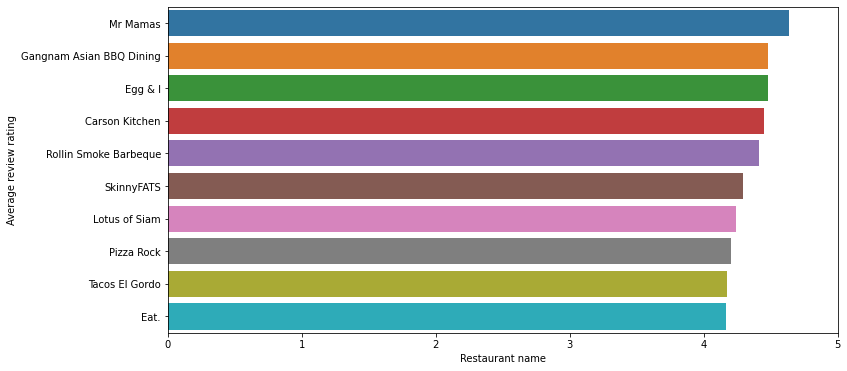

In [17]:
plt.figure(figsize=(12,6))
# Count Plot (a.k.a. Bar Plot)
x = top_10.name
sns.barplot(x='mean', y='name', data=top_10, order=x, orient='horizontal')

plt.xlabel('Restaurant name')
plt.ylabel('Average review rating')
plt.xlim(0,5)

### Word cloud for top 5

### Mr Mamas (p)

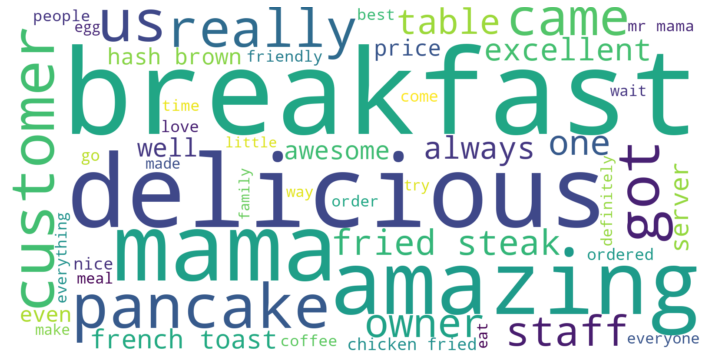

In [0]:
x = top_30.iloc[0, 0]
df1 = rev[rev.business_id == x]
build_word_cloud(df=df1, max_words=50, plt_height=6, plt_width=10)

### Gangnam Asian

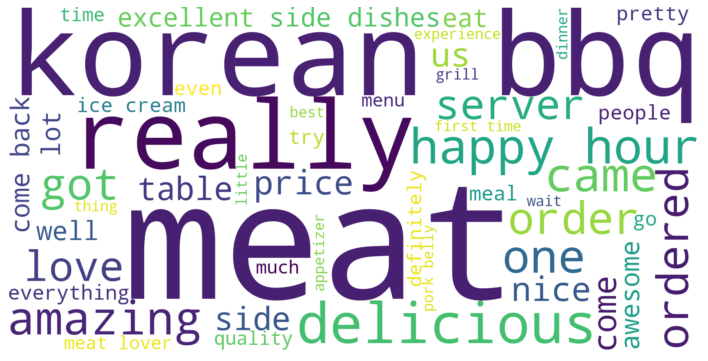

In [0]:
x = top_30.iloc[1, 0]
df1 = rev[rev.business_id == x]
build_word_cloud(df=df1, max_words=50, plt_height=6, plt_width=10)

### Egg and I

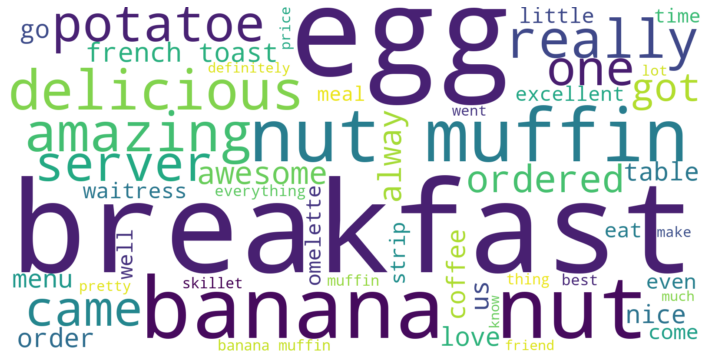

In [0]:
x = top_30.iloc[2, 0]
df1 = rev[rev.business_id == x]
build_word_cloud(df=df1, max_words=50, plt_height=6, plt_width=10)

### Carson kitchen

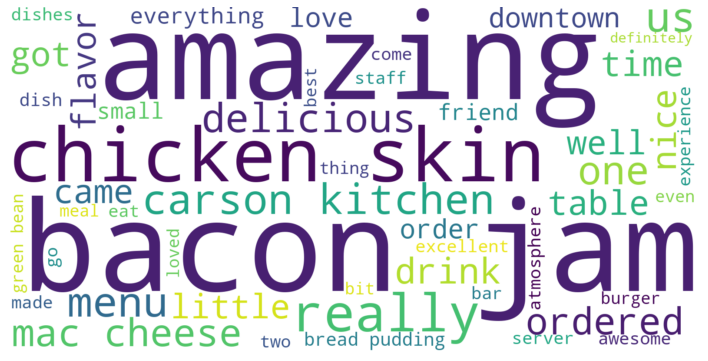

In [0]:
x = top_30.iloc[3, 0]
df1 = rev[rev.business_id == x]
build_word_cloud(df=df1, max_words=50, plt_height=6, plt_width=10)

### Rolling Smokes

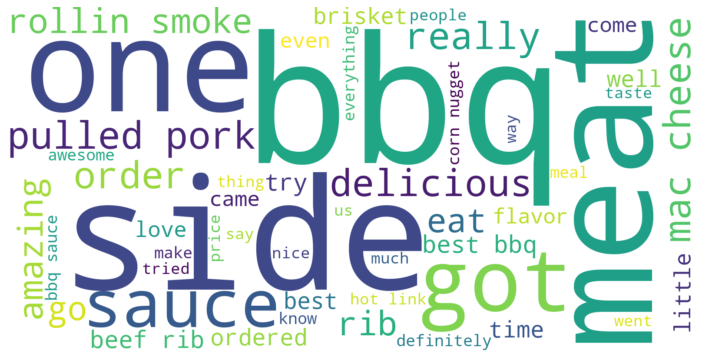

In [0]:
x = top_30.iloc[4, 0]
df1 = rev[rev.business_id == x]
build_word_cloud(df=df1, max_words=50, plt_height=6, plt_width=10)

In [0]:
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,text_clean,tokens_clean
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0,0,0,2016-01-17 05:26:22,the food is always good and the prices are rea...,"['food', 'always', 'good', 'prices', 'reasonab..."
1,qm97yMwREr7BKkexlwLFbg,TTRVdTXKcq-xn6-1IWbwEw,Gyrez6K8f1AyR7dzW9fvAw,5.0,0,0,1,2013-12-28 22:28:08,their pettuccine was fresh-made in the morning...,"['pettuccine', 'morning', 'delicate', 'yummy',..."
2,0AsmPiAQduxh5jE_si8cLA,C_hUvw2z0R-Rv0yZb6QCZA,dm6sO_Y8JdKTE1ZM955yug,5.0,0,0,0,2014-12-17 19:04:33,ended up here because raku was closed and it r...,"['ended', 'raku', 'closed', 'received', 'great..."
3,j3vP8537KHvoXNHQIr3haA,Z_HE_KKT7N-WddPTzUQC7A,jScBTQtdAt-8RshaiBEHgw,5.0,1,0,1,2018-05-28 20:56:05,"party of 3 ordered the fish tacos, pork belly ...","['party', 'ordered', 'fish', 'tacos', 'pork', ..."
4,f0B9-r14-bLudyu5S7aLhw,SvMGr_Oih7ivtzmnCL-Tmg,ujHiaprwCQ5ewziu0Vi9rw,1.0,1,0,0,2013-12-07 00:14:06,we had dinner at the bellagio buffet last nigh...,"['dinner', 'bellagio', 'buffet', 'last', 'nigh..."


### Is there a relationship between review length and ratings

In [0]:
rev['review_length'] = rev.apply(lambda x: len(x.tokens_clean.split(',')), axis=1)

In [0]:
# Subsetting based on review length because of outliers
sample = rev[rev.review_length <= 100]

Text(0, 0.5, 'frequency')

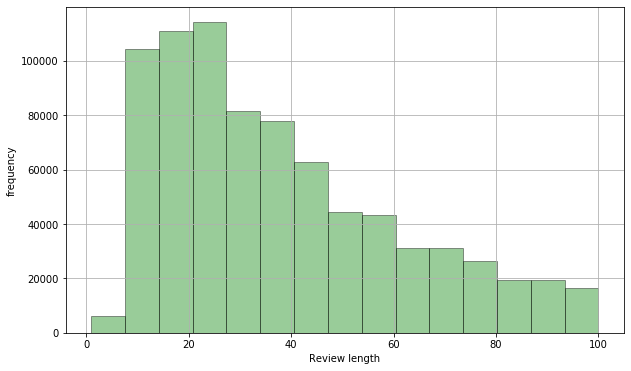

In [0]:
plt.figure(figsize=(10,6))
plt.grid()
sns.distplot(sample.review_length, kde=False, bins=15, color='green', hist_kws=dict(edgecolor="k", linewidth=1))
plt.xlabel('Review length')
plt.ylabel('frequency')

#### Majority are between 10 and 40 words long

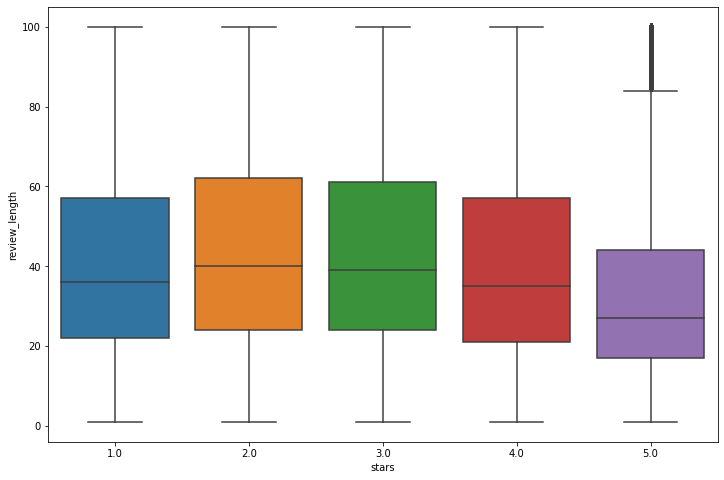

In [0]:
plt.figure(figsize=(12,8))
sns.boxplot(x='stars', y='review_length', data=sample)

#### With the exception of outliers, it seems the review length is shorter for higher ratings

## Inspections

### Distribution of demerits (p)

Text(0, 0.5, 'frequency')

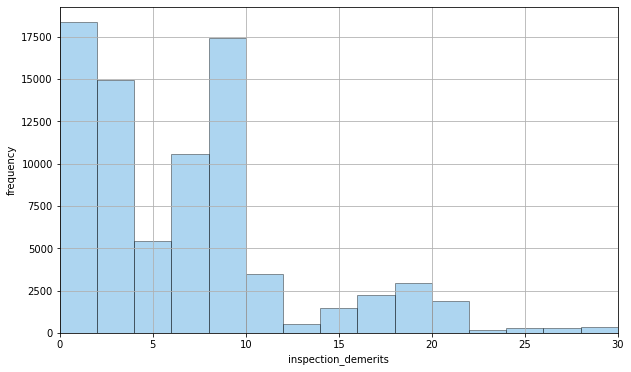

In [0]:
plt.figure(figsize=(10,6))
plt.grid()
dem = inspection.inspection_demerits
sns.distplot(dem, kde=False, color="#3498db", hist_kws=dict(edgecolor="k", linewidth=1))
plt.xlim(0,30)
plt.ylabel('frequency')

In [0]:
inspection = inspection.sort_values(['business_id', 'inspection_date']).reset_index(drop=True)

In [0]:
inspection.tail(5)

#### There is not much difference in distribution of demerits accross cities

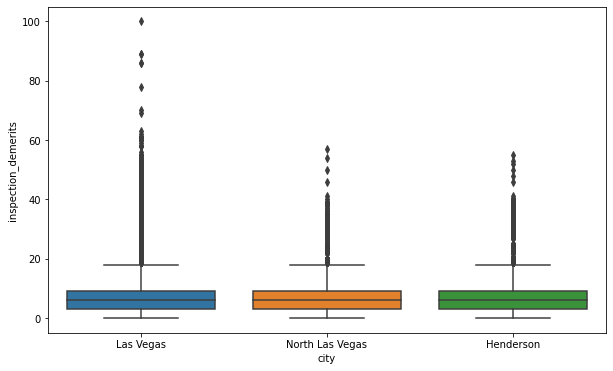

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(x='city', y='inspection_demerits', data=inspection, order=('Las Vegas', 'North Las Vegas', 'Henderson'))
# plt.ylim(0,30)

### The top 5 and bottom 5 restaurants (according to review ratings) have median demerits around acceptable values with more concerning outliers in the lower ranks

In [0]:
top_5 = top_30.iloc[:5]

In [0]:
subset = inspection[inspection.business_id.isin(top_5.business_id)].reset_index(drop=True)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

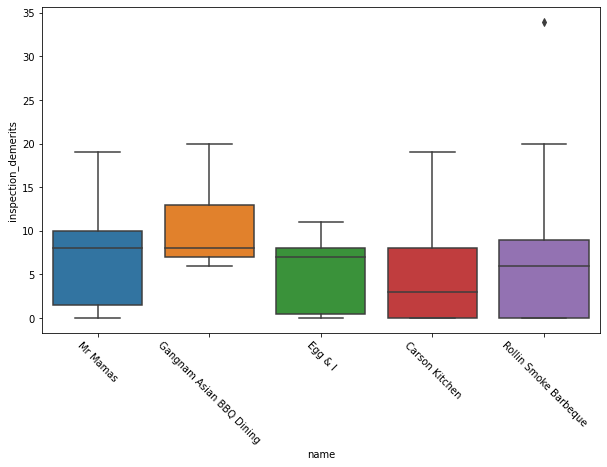

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(x='name', y='inspection_demerits', data=subset, order=top_5.name)
plt.xticks(rotation=-45)

In [45]:
# bottom 5
top = pd.DataFrame(top.to_records())
top.columns = ['business_id', 'count', 'mean']
top = top.loc[top['count'] > 1000, :]
top = top.sort_values('mean', ascending=False)
top = top.reset_index(drop=True)
top = pd.merge(top, inspection[['business_id', 'name']].drop_duplicates(), how='left', on='business_id')
bottom_5 = top[(top.shape[0] - 5): ]
bottom_5

,business_id,count,mean,name
115,ii8sAGBexBOJoYRFafF9XQ,2310,2.872727,Paris Las Vegas Hotel & Casino
116,El4FC8jcawUVgw_0EIcbaQ,3700,2.852432,MGM Grand Hotel
117,ByFMv3p5X1aNeZhU61rDcA,1925,2.561558,Stratosphere
118,4GXII-GU7S0ZyU6ElkhscQ,1436,2.330084,Hooters Casino Hotel Las Vegas
119,6Q7-wkCPc1KF75jZLOTcMw,2495,2.323046,Circus Circus Las Vegas Hotel and Casino


In [0]:
subset = inspection[inspection.business_id.isin(bottom_5.business_id)].reset_index(drop=True)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

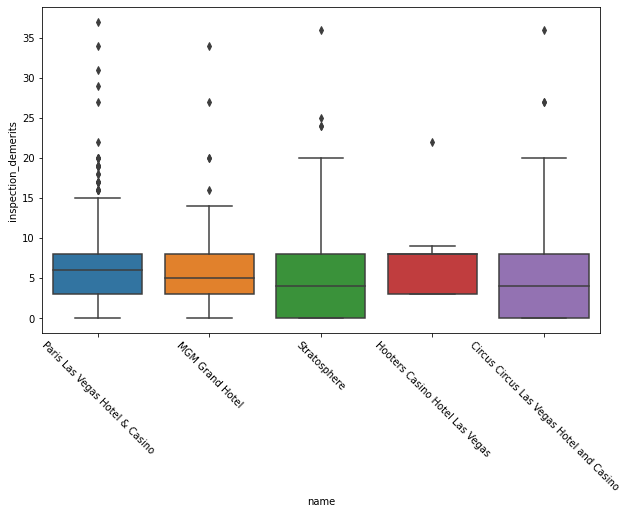

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(x='name', y='inspection_demerits', data=subset, order=bottom_5.name)
plt.xticks(rotation=-45)

### Distribution of Inspection grades (p)

In [0]:
sub = inspection[inspection.year.isin(['2016', '2017','2018'])]

<Figure size 864x432 with 0 Axes>

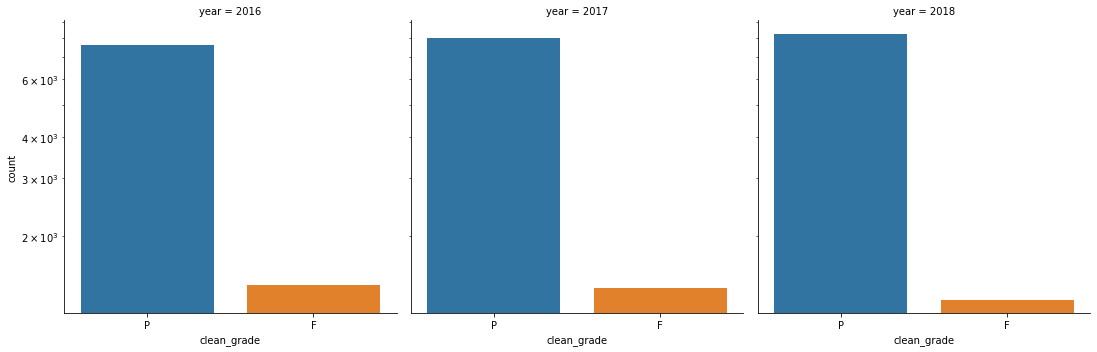

In [0]:
plt.figure(figsize=(12,6))
sns.catplot(x='clean_grade', data=sub, order=inspection.clean_grade.value_counts().index, col='year', kind='count')
# plt.grid()
plt.yscale('log')
plt.show()

In [0]:
rev.date = pd.to_datetime(rev.date)

In [0]:
rev.head()

In [0]:
inspection.tail(20)

,serial_number,permit_number,facility_id_x,inspection_date,inspection_time,employee_id,inspection_demerits,inspection_grade,inspection_grade_new,inspection_result,...,review_count,is_open,attributes,categories,zip_code,current_grade,current_demerits,previous_grade,date_previous,year
137826,DA0276013,PR0006285,FA0004345,2010-03-17,2010-03-17 14:30:00,EE7000857,10.0,A,A,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,0.0,B,2016-03-30 00:00:00,2010
137827,DA0276000,PR0006284,FA0004345,2011-03-15,2011-03-15 14:30:00,EE7000857,15.0,B,B,B Downgrade,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2011
137828,DA0276001,PR0006284,FA0004345,2011-05-06,2011-05-06 22:25:00,EE7000857,3.0,A,A,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2011
137829,DA0276014,PR0006285,FA0004345,2011-05-06,2011-05-06 23:05:00,EE7000857,8.0,A,A,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,0.0,B,2016-03-30 00:00:00,2011
137830,DA1012920,PR0006284,FA0004345,2012-09-19,2012-09-19 11:30:00,EE7001012,18.0,B,B,B Downgrade,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2012
137831,DA1029487,PR0006285,FA0004345,2012-11-30,2012-11-30 23:30:00,EE7001012,14.0,B,B,B Downgrade,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,0.0,B,2016-03-30 00:00:00,2012
137832,DA1029486,PR0006284,FA0004345,2012-11-30,NaN,EE7001089,22.0,C,C,C Downgrade,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2012
137833,DA1035870,PR0006285,FA0004345,2012-12-28,NaN,EE7001012,4.0,P,PASS,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,0.0,B,2016-03-30 00:00:00,2012
137834,DA1036087,PR0006284,FA0004345,2012-12-28,NaN,EE7001061,9.0,P,PASS,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2012
137835,DA1110455,PR0006284,FA0004345,2013-10-09,2013-10-09 21:20:00,EE7000857,9.0,A,A,Compliant,...,25.0,0.0,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Gay Bars, Dance Clubs, Nightlife",89119-6529,A,8.0,B,2016-03-30 00:00:00,2013


In [0]:
inspection.serial_number.nunique()

71176

In [0]:
inspection.shape[0]

81899

In [0]:
inspection.serial_number.value_counts()

In [0]:
inspection[inspection.serial_number=='DAL5NHOHI']

### Sentiment analysis

In [0]:
# !pip install vaderSentiment

In [0]:
from textblob import TextBlob

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [0]:
analyzer = SentimentIntensityAnalyzer()

In [0]:
rev['polarity_'] = rev['text_clean'].map(lambda text: analyzer.polarity_scores(str(text))['compound'])

In [0]:
rev.to_csv(r"/content/drive/My Drive/DPA Project files/review_tokenized.csv")

Read review file here

In [0]:
rev = pd.read_csv(r"/content/drive/My Drive/DPA Project files/review_tokenized.csv")

In [0]:
rev.date = pd.to_datetime(rev.date)
rev.drop(columns=[rev.columns[0]], inplace=True)


In [0]:
rev = rev[rev.year > 2009]

### Distribution of sentiment polarity (p)

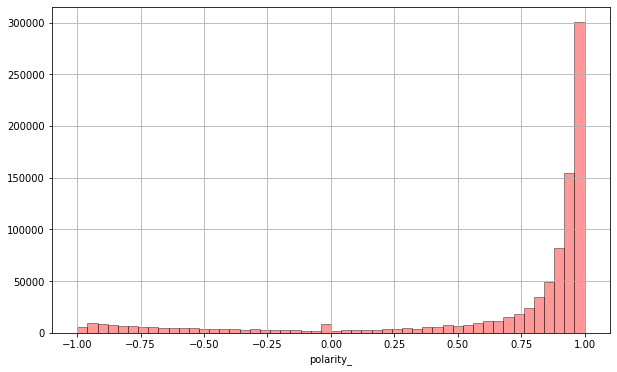

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(rev.polarity_, kde=False, color="r", hist_kws=dict(edgecolor="k", linewidth=1))
plt.grid()

In [0]:
def get_past_reviews(serial_number, window=90):
    inspection.inspection_date = pd.to_datetime(inspection.inspection_date)
    upper_date = inspection[inspection.serial_number==serial_number].inspection_date
    upper_date = upper_date.iloc[0]
    lower_date = upper_date - pd.to_timedelta(window, unit='d')
    b_id = inspection[inspection.serial_number==serial_number].business_id
    b_id = b_id.iloc[0]
    return (rev[(rev.business_id == b_id) & (rev.date.between(lower_date, upper_date))])
    

In [0]:
get_past_reviews('DA1677969')

In [0]:
# pip install -U textblob

Note: you may need to restart the kernel to use updated packages.


In [0]:
inspection.shape

(81899, 32)

In [0]:
# sample = inspection.sample(50000, random_state=42)
# sample['average_polarity'] = np.NAN
# for serial in sample.serial_number:
#     reviews = get_past_reviews(serial)
#     try:
#         avg_polarity = reviews.polarity.mean()
#         sample.loc[sample.serial_number==serial, 'average_polarity'] = avg_polarity
#     except:
#         continue


In [0]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='average_polarity', y='inspection_demerits', data=sample)

In [0]:
sample.head()

,serial_number,permit_number,facility_id_x,inspection_date,inspection_time,employee_id,inspection_demerits,inspection_grade,inspection_grade_new,inspection_result,...,is_open,attributes,categories,zip_code,current_grade,current_demerits,previous_grade,date_previous,year,average_polarity
41624,DA1027811,PR0021106,FA0010435,2012-11-26,2012-11-26 11:30:00,EE7001061,16.0,B,B,B Downgrade,...,1.0,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Seafood, American (Traditional), Restaurants, ...",89101-6823,A,0.0,A,2019-06-11 00:00:00,2012,0.220627
73345,DA1120744,PR0015706,FA0008394,2013-11-07,2013-11-07 14:50:00,EE7001145,10.0,A,A,Compliant,...,1.0,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Restaurants, American (Traditional), Food, San...",89169-6532,A,8.0,A,2019-06-27 00:00:00,2013,0.292345
47495,DAR0AF4IH,PR0011485,FA0006647,2018-10-02,2018-10-02 12:30:00,EE7001254,6.0,A,A,A Grade,...,1.0,"{'RestaurantsGoodForGroups': 'True', 'ByAppoin...","Cocktail Bars, Bars, Active Life, Aquariums, N...",89101-5603,A,0.0,A,2019-08-10 00:00:00,2018,0.141237
113734,DA1052651,PR0020101,FA0077343,2013-03-05,2013-03-05 14:30:00,EE7000691,5.0,A,A,Compliant,...,1.0,"{'RestaurantsAttire': ""u'casual'"", 'HasTV': 'F...","Caterers, Vegetarian, Sandwiches, Salad, Event...",89052,A,9.0,A,2020-01-23 00:00:00,2013,NaN
77973,DA1198194,PR0023008,FA0074666,2014-07-15,2014-07-15 11:20:00,EE7000674,6.0,A,A,Compliant,...,1.0,"{'RestaurantsReservations': 'False', 'Business...","Chinese, Korean, Restaurants",89146,A,3.0,A,2019-11-21 00:00:00,2014,NaN


### Unigrams and Bigrams (p)

In [0]:
def get_corpus(df):
    corpus = []
    # generating the corpus with repititions allowed
    for i in df.tokens_clean:
        all_words = []
        try:
            a = i.split(',')
        except: continue
        for j in a:
            try:
                j = re.findall('[a-z]', j)
                word = ''.join(j)
                all_words.append(word)
            except:
                continue
        all_words = list(filter(lambda a: a not in ['las', 'vegas','restaurant'], all_words))
        all_words_ = ' '.join(all_words)
        corpus.append(all_words_)
    return corpus

In [0]:
corpus = get_corpus(rev)

In [0]:
corpus = pd.Series(corpus, name='corp')

In [51]:
corpus.head()

0    food always good prices reasonable although ex...
1    pettuccine morning delicate yummy owner staffs...
2    ended raku closed received great ratings yelp ...
3    party ordered fish tacos pork belly banh mi co...
4    dinner bellagio buffet last night service serv...
Name: corp, dtype: object

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# Obtaining unigrams
def top_unigrams(corpus, n=10):
    vectorizer = CountVectorizer().fit(corpus)
    trans = vectorizer.transform(corpus)
    sum_words = trans.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return (pd.DataFrame(words_freq[:n], columns=['word', 'frequency']))

In [0]:
unigram = top_unigrams(corpus)

In [0]:
# obtaining bigrams
def top_bigrams(corpus, n=10):
    vectorizer = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    trans = vectorizer.transform(corpus)
    sum_words = trans.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return (pd.DataFrame(words_freq[:n], columns=['word', 'frequency']))

In [0]:
bigrams = top_bigrams(corpus)

### Top 10 Unigrams

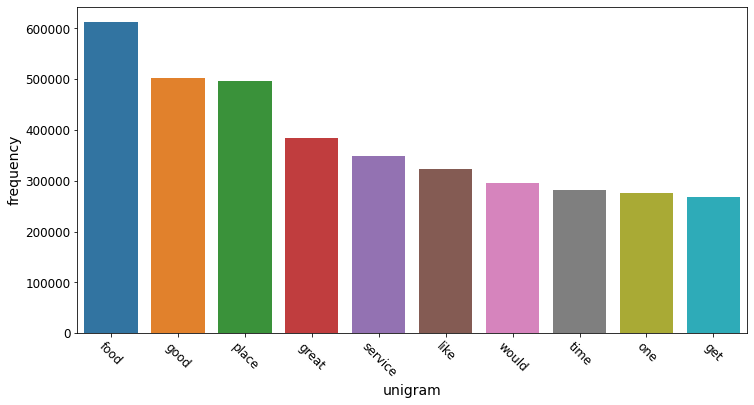

In [59]:
plt.figure(figsize=(12,6))
sns.barplot(x='word' , y='frequency', data=unigram)
plt.xticks(rotation=-45)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.xlabel('unigram',fontsize=14)
plt.ylabel('frequency',fontsize=14)
plt.show()

### Top 10 bigrams

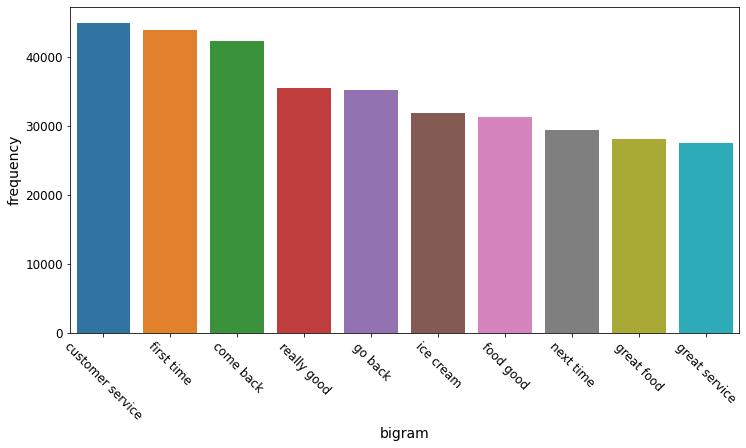

In [61]:
plt.figure(figsize=(12,6))
sns.barplot(x='word' , y='frequency', data=bigrams)
plt.xticks(rotation=-45)
plt.xlabel('bigram',fontsize=14)
plt.ylabel('frequency',fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

In [0]:
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,text_clean,tokens_clean,review_length,polarity,city
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...,"['food', 'always', 'good', 'prices', 'reasonable', 'although', 'exactly', 'restaurant', 'like', ...",37.0,0.272321,Las Vegas
1,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...,"['food', 'always', 'good', 'prices', 'reasonable', 'although', 'exactly', 'restaurant', 'like', ...",37.0,0.272321,Las Vegas
2,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...,"['food', 'always', 'good', 'prices', 'reasonable', 'although', 'exactly', 'restaurant', 'like', ...",37.0,0.272321,Las Vegas
3,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...,"['food', 'always', 'good', 'prices', 'reasonable', 'although', 'exactly', 'restaurant', 'like', ...",37.0,0.272321,Las Vegas
4,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are reasonable. although it is not exactly a restaurant ...,"['food', 'always', 'good', 'prices', 'reasonable', 'although', 'exactly', 'restaurant', 'like', ...",37.0,0.272321,Las Vegas


In [0]:
rev = pd.merge(rev, inspection[['business_id', 'city']], on='business_id', how='left')

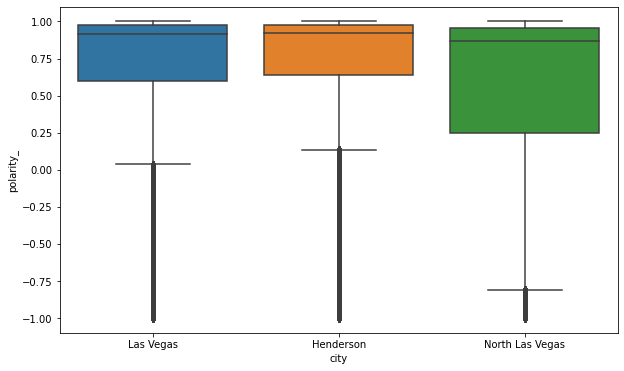

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(x='city', y='polarity_', data=rev[['city', 'polarity_']])
plt.show()

### Inspections per year (p)

In [0]:
inspection.head(1)

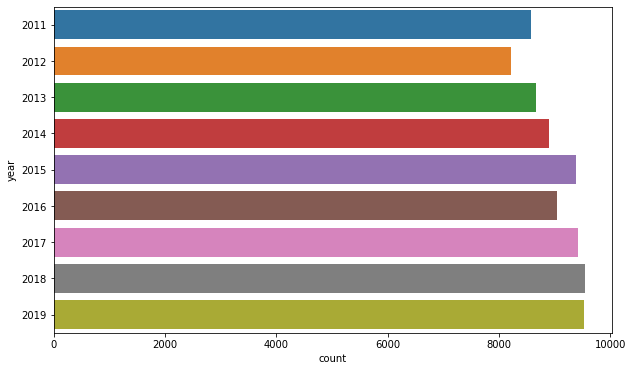

In [0]:
plt.figure(figsize=(10,6))
sns.countplot(y=inspection.loc[~inspection.year.isin([2020]), 'year'], data=inspection, orient='h')
plt.show()

  ### Distribution of number of reviews pre-inspection (12-month window) (p)

In [0]:
sample = inspection.sample(2000).reset_index(drop=True)
sample['num_past_reviews'] = np.NaN

In [0]:
for serial in sample.serial_number:
  sample.loc[sample.serial_number == serial, 'num_past_reviews'] = get_past_reviews(serial_number=serial, window=365).shape[0]

### Weather

In [0]:
weather = pd.read_csv(r"/content/drive/My Drive/DPA Project files/LasVegasWeather.csv")

In [0]:
cols = []
for i in range(len(weather.columns)):
  cols.append(weather.columns[i].lower())
weather.columns = cols

In [0]:
weather.head(1)

,station,date,latitude,longitude,elevation,name,temp,temp_attributes,dewp,dewp_attributes,slp,slp_attributes,stp,stp_attributes,visib,visib_attributes,wdsp,wdsp_attributes,mxspd,gust,max,max_attributes,min,min_attributes,prcp,prcp_attributes,sndp,frshtt
0,72387003160,2004-01-01,36.6206,-116.0278,984.5,"MERCURY DESERT ROCK AIRPORT, NV US",39.3,24,27.7,24,1014.7,24,999.9,0,9.9,24,6.5,24,22.9,34.0,55.9,,28.9,,0.0,D,999.9,0


In [0]:
weather.date = pd.to_datetime(weather.date)

In [0]:
weather = weather[weather.date > "2011-01-01"]

In [0]:
weather.shape

(71557, 28)

In [0]:
inspection.drop(columns=inspection.columns[0], axis=1, inplace=True)

In [0]:
def get_nearest_station(serial):
  sub = inspection[inspection.serial_number == serial]
  lon = sub.longitude_x.values[0]
  lat = sub.latitude_x.values[0]
  long_range = (lon + 0.15, lon - 0.15)
  lat_range = (lat + 0.15, lat - 0.15)
  date = sub.inspection_date.values[0]
  try:
    x = weather[(weather.longitude <= long_range[0]) & (weather.longitude >= long_range[1]) & 
              (weather.latitude <= lat_range[0]) & (weather.latitude >= lat_range[1]) & (weather.date == date)]
    return(x)
  except:
    return (None)

  

In [0]:
inspection.tail(2)

In [0]:
sample = inspection.sample(5000)

In [0]:
sample['temp'] = np.NaN
sample['prcp'] = np.NaN
sample['dewp'] = np.NaN
for i in sample.serial_number:
  try:
    sample.loc[sample.serial_number==i, 'temp'] = get_nearest_station(i).head(1).temp.values[0]
    sample.loc[sample.serial_number==i, 'prcp'] = get_nearest_station(i).head(1).prcp.values[0]
    sample.loc[sample.serial_number==i, 'dewp'] = get_nearest_station(i).head(1).dewp.values[0]
  except: continue

In [0]:
sample = sample[sample.temp.notna()]

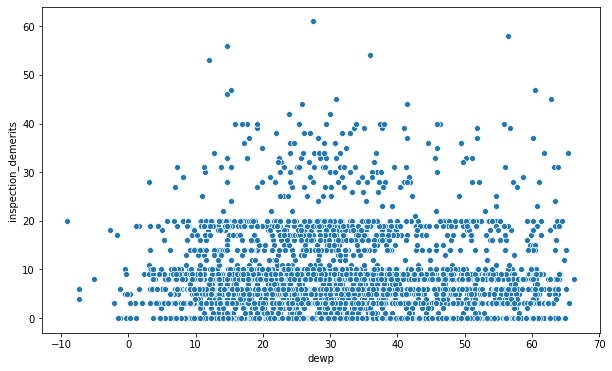

In [0]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='dewp', y='inspection_demerits', data=sample)
# plt.ylim(20,)

### Sentiment polarity with time

In [0]:
rev['year'] = pd.DatetimeIndex(rev.date).year

In [0]:
rev.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,date,text_clean,tokens_clean,review_length,polarity,polarity_,city,year
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are rea...,"['food', 'always', 'good', 'prices', 'reasonab...",37.0,0.272321,0.872,Las Vegas,2016.0


In [0]:
rev =  rev[rev.year > 2010]

In [0]:
# Average polarity over time is pretty much the same
df = rev.groupby('year')['polarity_'].mean().to_frame().reset_index()
df.year = df.year.astype(int)
df

,year,polarity_
0,2011,0.710436
1,2012,0.682424
2,2013,0.666584
3,2014,0.625158
4,2015,0.600918
5,2016,0.574402
6,2017,0.567858
7,2018,0.553348


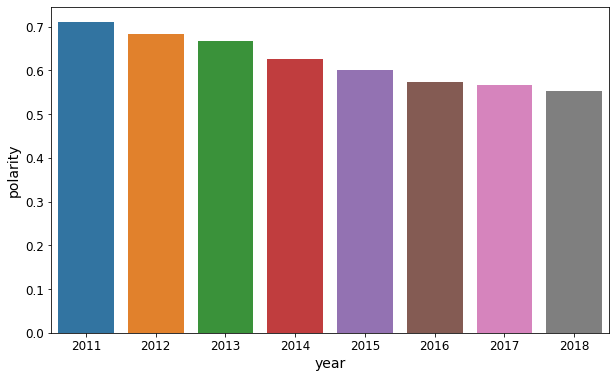

In [0]:
plt.figure(figsize=(10,6))
sns.barplot(x='year', y='polarity_', data=df)
plt.xlabel('year', fontsize=14)
plt.ylabel('polarity', fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

In [0]:
rev['month'] = pd.DatetimeIndex(rev.date).month

In [0]:
rev.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,date,text_clean,tokens_clean,review_length,polarity,polarity_,city,year,month
0,IByf6mVY0WA838XNSh-5MA,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,0.0,0.0,0.0,2016-01-17 05:26:22,the food is always good and the prices are rea...,"['food', 'always', 'good', 'prices', 'reasonab...",37.0,0.272321,0.872,Las Vegas,2016.0,1


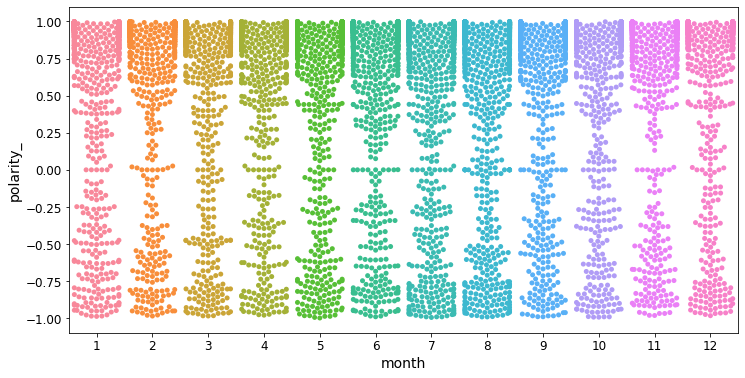

In [0]:
sub = rev.sample(10000)
plt.figure(figsize=(12,6))
plt.xlabel('month', fontsize=14)
plt.ylabel('polarity', fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
sns.swarmplot(x='month', y='polarity_', data=sub, size=5)

In [0]:
df = rev.groupby('month')['polarity_'].mean().to_frame().reset_index()
df

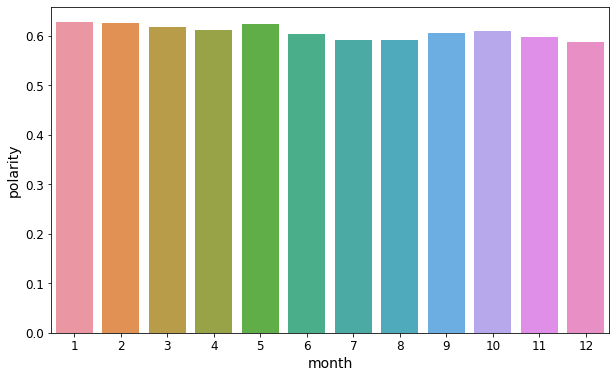

In [0]:
plt.figure(figsize=(10,6))
sns.barplot(x='month', y='polarity_', data=df)
plt.xlabel('month', fontsize=14)
plt.ylabel('polarity', fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()